<img src="../../../images/banners/pandas-cropped.jpeg" width="600"/>

<a class="anchor" id="intro_to_data_structures"></a>
# <img src="../../../images/logos/pandas.png" width="23"/> DataFrame (Part #2)

## <img src="../../../images/logos/toc.png" width="20"/> Table of Contents
* [Assigning new columns in method chains](#assigning_new_columns_in_method_chains)
* [Indexing / selection](#indexing_/_selection)
* [Data alignment and arithmetic](#data_alignment_and_arithmetic)
* [Transposing](#transposing)
* [DataFrame interoperability with NumPy functions](#dataframe_interoperability_with_numpy_functions)
* [Console display](#console_display)
* [DataFrame column attribute access and IPython completion](#dataframe_column_attribute_access_and_ipython_completion)

---

Now that you know the basics of how to create a dataframe and modify it, let's learn more.

<a class="anchor" id="assigning_new_columns_in_method_chains"></a>
## Assigning new columns in method chains

Inspired by [dplyr’s](https://dplyr.tidyverse.org/reference/mutate.html)
`mutate` verb, DataFrame has an [`assign()`](../reference/api/pandas.DataFrame.assign.html#pandas.DataFrame.assign "pandas.DataFrame.assign")
method that allows you to easily create new columns that are potentially
derived from existing columns.

In [46]:
iris = pd.read_csv("../../data/iris.data")

In [47]:
iris.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Name
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [48]:
iris.assign(sepal_ratio=iris["SepalWidth"] / iris["SepalLength"]).head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Name,sepal_ratio
0,5.1,3.5,1.4,0.2,Iris-setosa,0.686275
1,4.9,3.0,1.4,0.2,Iris-setosa,0.612245
2,4.7,3.2,1.3,0.2,Iris-setosa,0.680851
3,4.6,3.1,1.5,0.2,Iris-setosa,0.673913
4,5.0,3.6,1.4,0.2,Iris-setosa,0.720000


In the example above, we inserted a precomputed value. We can also pass in
a function of one argument to be evaluated on the DataFrame being assigned to.

In [49]:
iris.assign(sepal_ratio=lambda x: (x["SepalWidth"] / x["SepalLength"])).head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Name,sepal_ratio
0,5.1,3.5,1.4,0.2,Iris-setosa,0.686275
1,4.9,3.0,1.4,0.2,Iris-setosa,0.612245
2,4.7,3.2,1.3,0.2,Iris-setosa,0.680851
3,4.6,3.1,1.5,0.2,Iris-setosa,0.673913
4,5.0,3.6,1.4,0.2,Iris-setosa,0.720000


`assign` **always** returns a copy of the data, leaving the original
DataFrame untouched.

Passing a callable, as opposed to an actual value to be inserted, is
useful when you don’t have a reference to the DataFrame at hand. This is
common when using `assign` in a chain of operations. For example,
we can limit the DataFrame to just those observations with a Sepal Length
greater than 5, calculate the ratio, and plot:

<AxesSubplot:xlabel='SepalRatio', ylabel='PetalRatio'>

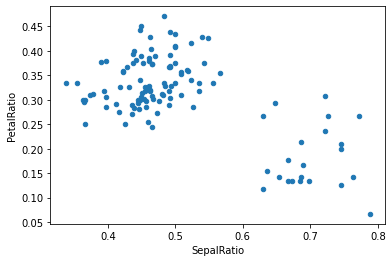

In [50]:
%matplotlib inline
(
    iris.query("SepalLength > 5")
    .assign(
        SepalRatio=lambda x: x.SepalWidth / x.SepalLength,
        PetalRatio=lambda x: x.PetalWidth / x.PetalLength,
    )
    .plot(kind="scatter", x="SepalRatio", y="PetalRatio")
)

<a class="anchor" id="indexing_/_selection"></a>
## Indexing / selection

The basics of indexing are as follows:


|Operation|Syntax|Result|
|:--|:--|:--|
|Select column|`df[col]`|Series|
|Select row by label|`df.loc[label]`|Series|
|Select row by integer location|`df.iloc[loc]`|Series|
|Slice rows|`df[5:10]`|DataFrame|
|Select rows by boolean vector|`df[bool_vec]`|DataFrame|

Row selection, for example, returns a Series whose index is the columns of the
DataFrame:

In [51]:
df.loc["b"]

one            2.0
bar            2.0
flag         False
foo            bar
one_trunc      2.0
Name: b, dtype: object

In [52]:
df.iloc[2]

one           3.0
bar           3.0
flag         True
foo           bar
one_trunc     NaN
Name: c, dtype: object

> A more exhaustive treatment of sophisticated label-based indexing and
slicing, will be covered later. We will address the
fundamentals of reindexing / conforming to new sets of labels.

<a class="anchor" id="data_alignment_and_arithmetic"></a>
## Data alignment and arithmetic

Data alignment between DataFrame objects automatically align on **both the
columns and the index (row labels)**. Again, the resulting object will have the
union of the column and row labels.

In [53]:
df = pd.DataFrame(np.random.randn(10, 4), columns=["A", "B", "C", "D"])

In [54]:
df2 = pd.DataFrame(np.random.randn(7, 3), columns=["A", "B", "C"])

In [55]:
df + df2

,A,B,C,D
0,-0.801713,-1.004270,-1.399830,NaN
1,-0.675490,1.391420,1.511100,NaN
2,2.044998,-1.376368,-1.778327,NaN
3,2.209413,-0.517473,-1.519804,NaN
4,0.692652,1.428191,-0.002440,NaN
5,-0.932095,1.305450,-0.316591,NaN
6,-0.995912,0.502952,-0.008971,NaN
7,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN


When doing an operation between DataFrame and Series, the default behavior is
to align the Series **index** on the DataFrame **columns**, thus [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html)
row-wise. For example:

In [56]:
df - df.iloc[0]

,A,B,C,D
0,0.000000,0.000000,0.000000,0.000000
1,-1.764312,-0.059506,2.481340,-1.602537
2,-0.241024,-2.397195,0.357747,-2.522988
3,0.631792,0.305899,0.502190,0.093457
4,0.730656,0.175708,0.367927,-0.866917
5,-1.177103,0.928325,2.315187,-1.279728
6,-1.661171,0.153009,2.211896,0.033099
7,-1.946002,-0.615090,1.723518,-1.232338
8,0.216157,-0.152853,3.696943,-1.668246
9,-0.520928,0.644696,1.512962,-0.359320


Operations with scalars are just as you would expect:

In [57]:
df * 5 + 2

,A,B,C,D
0,3.196248,3.630071,-4.827519,5.194073
1,-5.625314,3.332540,7.579182,-2.818613
2,1.991128,-8.355903,-3.038783,-7.420866
3,6.355209,5.159564,-2.316569,5.661360
4,6.849529,4.508610,-2.987883,0.859490
5,-2.689266,8.271698,6.748418,-1.204565
6,-5.109605,4.395117,6.231963,5.359569
7,-6.533759,0.554619,3.790073,-0.967615
8,4.277033,2.865804,13.657193,-3.147157
9,0.591610,6.853552,2.737289,3.397474


In [58]:
1 / df

,A,B,C,D
0,4.179734,3.067351,-0.732330,1.565399
1,-0.655711,3.752231,0.896189,-1.037643
2,-563.542597,-0.482816,-0.992303,-0.530737
3,1.148051,1.582497,-1.158327,1.365613
4,1.031028,1.993135,-1.002429,-4.384002
5,-1.066265,0.797232,1.052982,-1.560274
6,-0.703274,2.087581,1.181485,1.488286
7,-0.585908,-3.459296,2.793182,-1.684854
8,2.195840,5.774977,0.428920,-0.971410
9,-3.550153,1.030173,6.781605,3.577884


In [59]:
df ** 4

,A,B,C,D
0,3.276465e-03,0.011297,3.476736,0.166533
1,5.409422e+00,0.005045,1.550251,0.862598
2,9.915007e-12,18.402291,1.031389,12.603269
3,5.756465e-01,0.159451,0.555488,0.287534
4,8.849486e-01,0.063365,0.990341,0.002707
5,7.736408e-01,2.475487,0.813422,0.168732
6,4.087915e+00,0.052653,0.513201,0.203823
7,8.485579e+00,0.006983,0.016429,0.124094
8,4.301277e-02,0.000899,29.545816,1.123025
9,6.295230e-03,0.887889,0.000473,0.006102


Boolean operators work as well:

In [60]:
df1 = pd.DataFrame({"a": [1, 0, 1], "b": [0, 1, 1]}, dtype=bool)
df2 = pd.DataFrame({"a": [0, 1, 1], "b": [1, 1, 0]}, dtype=bool)

In [61]:
df1 & df2

,a,b
0,False,False
1,False,True
2,True,False


In [62]:
df1 | df2

,a,b
0,True,True
1,True,True
2,True,True


In [63]:
df1 ^ df2

,a,b
0,True,True
1,True,False
2,False,True


In [64]:
-df1

,a,b
0,False,True
1,True,False
2,False,False


<a class="anchor" id="transposing"></a>
### Transposing

To transpose, access the `T` attribute (also the `transpose` function),
similar to an ndarray:

In [65]:
df[:5].T

,0,1,2,3,4
A,0.239250,-1.525063,-0.001774,0.871042,0.969906
B,0.326014,0.266508,-2.071181,0.631913,0.501722
C,-1.365504,1.115836,-1.007757,-0.863314,-0.997577
D,0.638815,-0.963723,-1.884173,0.732272,-0.228102


<a class="anchor" id="dataframe_interoperability_with_numpy_functions"></a>
## DataFrame interoperability with NumPy functions

Elementwise NumPy ufuncs (log, exp, sqrt, …) and various other NumPy functions
can be used with no issues on Series and DataFrame, assuming the data within
are numeric:

In [66]:
np.exp(df)

,A,B,C,D
0,1.270296,1.385435,0.255252,1.894234
1,0.217607,1.305398,3.052120,0.381470
2,0.998227,0.126037,0.365037,0.151955
3,2.389399,1.881205,0.421762,2.079801
4,2.637696,1.651563,0.368772,0.796043
5,0.391467,3.505523,2.584892,0.526811
6,0.241250,1.614497,2.331222,1.957981
7,0.181454,0.748955,1.430486,0.552378
8,1.576814,1.189057,10.292739,0.357210
9,0.754517,2.639819,1.158884,1.322462


In [67]:
np.asarray(df)

array([[ 2.39249694e-01,  3.26014207e-01, -1.36550387e+00,
         6.38814689e-01],
       [-1.52506275e+00,  2.66508097e-01,  1.11583631e+00,
        -9.63722628e-01],
       [-1.77448875e-03, -2.07118062e+00, -1.00775662e+00,
        -1.88417311e+00],
       [ 8.71041725e-01,  6.31912716e-01, -8.63313716e-01,
         7.32272092e-01],
       [ 9.69905710e-01,  5.01722065e-01, -9.97576536e-01,
        -2.28102088e-01],
       [-9.37853158e-01,  1.25433963e+00,  9.49683600e-01,
        -6.40913093e-01],
       [-1.42192100e+00,  4.79023382e-01,  8.46392511e-01,
         6.71913735e-01],
       [-1.70675181e+00, -2.89076140e-01,  3.58014568e-01,
        -5.93523075e-01],
       [ 4.55406624e-01,  1.73160875e-01,  2.33143868e+00,
        -1.02943131e+00],
       [-2.81677986e-01,  9.70710477e-01,  1.47457719e-01,
         2.79494829e-01]])

DataFrame is not intended to be a drop-in replacement for ndarray as its
indexing semantics and data model are quite different in places from an n-dimensional
array.

[`Series`](../reference/api/pandas.Series.html#pandas.Series "pandas.Series") implements `__array_ufunc__`, which allows it to work with NumPy’s
[universal functions](https://numpy.org/doc/stable/reference/ufuncs.html).

The ufunc is applied to the underlying array in a Series.

In [68]:
ser = pd.Series([1, 2, 3, 4])

In [69]:
np.exp(ser)

0     2.718282
1     7.389056
2    20.085537
3    54.598150
dtype: float64

Like other parts of the library, pandas will automatically align labeled inputs
as part of a ufunc with multiple inputs. For example, using `numpy.remainder()`
on two [`Series`](../reference/api/pandas.Series.html#pandas.Series "pandas.Series") with differently ordered labels will align before the operation.

In [70]:
ser1 = pd.Series([1, 2, 3], index=["a", "b", "c"])
ser2 = pd.Series([1, 3, 5], index=["b", "a", "c"])

In [71]:
ser1

a    1
b    2
c    3
dtype: int64

In [72]:
ser2

b    1
a    3
c    5
dtype: int64

In [73]:
np.remainder(ser1, ser2)

a    1
b    0
c    3
dtype: int64

As usual, the union of the two indices is taken, and non-overlapping values are filled
with missing values.

In [74]:
ser3 = pd.Series([2, 4, 6], index=["b", "c", "d"])

In [75]:
ser3

b    2
c    4
d    6
dtype: int64

In [76]:
np.remainder(ser1, ser3)

a    NaN
b    0.0
c    3.0
d    NaN
dtype: float64

<a class="anchor" id="console_display"></a>
## Console display

Very large DataFrames will be truncated to display them in the console.
You can also get a summary using [`info()`](../reference/api/pandas.DataFrame.info.html#pandas.DataFrame.info "pandas.DataFrame.info").
(Here I am reading a CSV version of the **baseball** dataset from the **plyr**
R package):

In [77]:
baseball = pd.read_csv("./../../data/baseball.csv")

In [78]:
baseball.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      100 non-null    int64  
 1   player  100 non-null    object 
 2   year    100 non-null    int64  
 3   stint   100 non-null    int64  
 4   team    100 non-null    object 
 5   lg      100 non-null    object 
 6   g       100 non-null    int64  
 7   ab      100 non-null    int64  
 8   r       100 non-null    int64  
 9   h       100 non-null    int64  
 10  X2b     100 non-null    int64  
 11  X3b     100 non-null    int64  
 12  hr      100 non-null    int64  
 13  rbi     100 non-null    float64
 14  sb      100 non-null    float64
 15  cs      100 non-null    float64
 16  bb      100 non-null    int64  
 17  so      100 non-null    float64
 18  ibb     100 non-null    float64
 19  hbp     100 non-null    float64
 20  sh      100 non-null    float64
 21  sf      100 non-null    float64
 22  gid

You can adjust the max width of the individual columns by setting `display.max_colwidth`

In [83]:
datafile = {
    "filename": ["filename_01", "filename_02"],
    "path": [
        "media/user_name/storage/folder_01/filename_01",
        "media/user_name/storage/folder_02/filename_02",
    ],
}

In [84]:
pd.set_option("display.max_colwidth", 30)

In [85]:
pd.DataFrame(datafile)

,filename,path
0,filename_01,media/user_name/storage/fo...
1,filename_02,media/user_name/storage/fo...


In [86]:
pd.set_option("display.max_colwidth", 100)

In [87]:
pd.DataFrame(datafile)

,filename,path
0,filename_01,media/user_name/storage/folder_01/filename_01
1,filename_02,media/user_name/storage/folder_02/filename_02


You can also set this settings with:

In [86]:
pd.options.display.max_colwidth = 100

Similar settings also exist for:
- `pd.options.display.max_rows`
- `pd.options.display.max_columns`
- `pd.options.display.precision`

The `precision` option sets the number of decimals to be displayed in a dataframe.

In [90]:
df = pd.DataFrame(np.random.rand(3, 4))
df

,0,1,2,3
0,0.561481,0.170352,0.114887,0.666560
1,0.173273,0.436498,0.459674,0.452534
2,0.186400,0.870457,0.243567,0.702583


In [91]:
pd.options.display.precision = 3

In [92]:
df

,0,1,2,3
0,0.561,0.170,0.115,0.667
1,0.173,0.436,0.460,0.453
2,0.186,0.870,0.244,0.703


<a class="anchor" id="dataframe_column_attribute_access_and_ipython_completion"></a>
## DataFrame column attribute access and IPython completion

If a DataFrame column label is a valid Python variable name, the column can be
accessed like an attribute:

In [88]:
df = pd.DataFrame({"foo1": np.random.randn(5), "foo2": np.random.randn(5)})
df

,foo1,foo2
0,1.347191,-1.724793
1,0.997323,-0.701355
2,-1.996298,-1.061464
3,1.345530,0.210715
4,0.014961,0.229168


In [89]:
df.foo1

0    1.347191
1    0.997323
2   -1.996298
3    1.345530
4    0.014961
Name: foo1, dtype: float64

The columns are also connected to the [IPython](https://ipython.org)
completion mechanism so they can be tab-completed:

```python
df.foo<TAB>  # noqa: E225, E999
```